# Plot for Summary Report: Regression Analysis

In [1]:
%run 'helpers-for-report-plot-generation.ipynb'

In [2]:
def get_data():
    """Get raw data from local database"""
    milk = get_dataset('milk_volume')
    birthdates = get_dataset('birthdates')
    genetics = get_dataset('genetics')
    classification = get_dataset('classification')
        
    return select_milk_features(milk), \
           select_birthdate_features(birthdates), \
           select_genetics_features(genetics), \
           select_classification_features(classification)
    
def select_milk_features(milk):
    """Prepare and select milk features"""
    
    milk = milk.rename(columns={'date':'milk_date'})
    milk = milk.dropna(axis=0, how='any')
    milk = milk.sort_values(['milk_date', 'animal_id']).reset_index()
    
    features = ['animal_id', 'milk_date', 'milk_weight', 'days_since_calving']
    return milk[features]

def select_birthdate_features(birthdates):
    """Prepare and select birthdate features"""
    
    birthdates = birthdates.sort_values(['birthdate']).reset_index()
    
    features = ['animal_id', 'birthdate']
    return birthdates[features]

def select_genetics_features(genetics):
    """Prepare and select genetics features"""
    genetics = genetics.rename(columns={'milk':'milk_score'})
    
    features = ['animal_id', 'milk_score', 'ctpi']
    return genetics[features]

def select_classification_features(classifications):
    """Prepare and select genetics features"""
    
    classifications = classifications.sort_values(['animal_id', 'date'])
    classifications = classifications.drop_duplicates(subset=['animal_id'], keep='last').reset_index()
    
    features = ['animal_id', 'dairy_form', 'udder_score_aggregate', 'dairy_strength_aggregate', \
                'final_score', 'breed_age_average']
    return classifications[features]

In [3]:
def build_annual_performance_profiles(milk, birthdates):
    """Takes milk data and and calculates the performance profiles of each animal by calendar year."""
    years = milk['milk_date'].dt.year.unique()
    profiles = []
    
    for year in years:
        year_mask = (milk['milk_date'].dt.year == year)
        milk_for_year = milk[year_mask]
        
        for animal_id in milk['animal_id'].unique():    
            animal_milk_for_year = milk_for_year[milk_for_year['animal_id'] == animal_id]
            
            profile = {}
            profile['animal_id'] = animal_id
            profile['year'] = year
            
            profile['days_milked'] = animal_milk_for_year.count()['animal_id']
            if profile['days_milked'] == 0:
                profile['days_milked'] = np.NaN
            
            profile['total_milkweight'] = animal_milk_for_year['milk_weight'].sum()
            if profile['total_milkweight'] == 0:
                 profile['total_milkweight'] = np.NaN
            
            profile['milkweight_per_day'] = animal_milk_for_year['milk_weight'].mean()
            if profile['total_milkweight'] == 0:
                profile['total_milkweight'] = np.NaN
            
            profiles.append(profile)
         
    data = pd.DataFrame(profiles)
    data.describe()
    data = data.sort_values(['year', 'animal_id', 'milkweight_per_day']).reset_index()
    features = ['year', 'animal_id', 'days_milked', 'milkweight_per_day', 'total_milkweight']
    return data[features]

In [4]:
def append_previous_year_profiles_to_milk_data(milk, profiles):
    """For each milk_date, animal_id combination, retrieve the profile from the previous year and merge to dataframe"""
    
    milk['prior_year'] = milk['milk_date'].dt.year - 1
    milk = milk.set_index(['milk_date'])['2016-01-01':'2017-12-31'].reset_index()
    
    data = pd.merge(left=milk, right=profiles, left_on=['prior_year', 'animal_id'], right_on=['year', 'animal_id'])
    features = ['milk_date', 'animal_id', 'milk_weight', 'days_since_calving', 'milkweight_per_day']
    
    return data[features].rename(columns={'milkweight_per_day':'prior_year_milkweight_per_day'})

In [5]:
def append_months_aged_to_milk_data(milk, birthdates):
    """Calcualte the number of months aged for on each milking date"""
    data = pd.merge(left=milk, right=birthdates, left_on='animal_id', right_on='animal_id')
    data['age_in_months'] = (data['milk_date'] - data['birthdate']).astype('timedelta64[M]')
    
    features = ['milk_date', 'animal_id', 'milk_weight', 'age_in_months', \
                'prior_year_milkweight_per_day', 'days_since_calving']
    return data[features]

In [6]:
def aggregate_data_for_regression(milk, genetics, classification):
    """Merge Genetics, Milk, and Classification Data Sets"""
    data = pd.merge(left=milk, right=genetics, left_on='animal_id', right_on='animal_id')
    data = pd.merge(left=data, right=classification, left_on='animal_id', right_on='animal_id')    
    return data

In [16]:
def get_data_for_analysis():
    milk, birthdates, genetics, classification = get_data()
    profiles = build_annual_performance_profiles(milk, birthdates)
    milk = append_previous_year_profiles_to_milk_data(milk, profiles)
    milk = append_months_aged_to_milk_data(milk, birthdates)
    return aggregate_data_for_regression(milk, genetics, classification)

data = get_data_for_analysis()
data = data.dropna()
data = data[data['days_since_calving'] < 305]
data.sample(10)

,milk_date,animal_id,milk_weight,age_in_months,prior_year_milkweight_per_day,days_since_calving,milk_score,ctpi,dairy_form,udder_score_aggregate,dairy_strength_aggregate,final_score,breed_age_average
39205,2016-08-06,2071,62.4,33.0,45.160000,228.0,-243,1659,21.0,85.0,81.0,83.0,104.900002
5771,2016-12-15,1831,99.4,70.0,86.211667,201.0,164,1572,30.0,81.0,85.0,81.0,101.699997
15875,2017-03-25,1944,74.8,58.0,79.400000,213.0,-217,1647,25.0,78.0,82.0,80.0,102.900002
22843,2017-06-28,1991,88.8,55.0,76.475077,143.0,805,1950,31.0,83.0,86.0,83.0,107.199997
40146,2017-07-27,2073,58.8,44.0,59.563696,250.0,-238,1643,24.0,79.0,78.0,78.0,100.900002
18594,2016-09-30,1964,49.4,50.0,81.375556,75.0,178,1632,24.0,84.0,81.0,83.0,103.699997
11013,2017-01-26,1886,44.1,65.0,77.439735,197.0,-608,1493,45.0,84.0,88.0,85.0,106.000000
20510,2016-12-15,1977,89.3,51.0,62.716026,136.0,-76,1541,42.0,86.0,88.0,85.0,106.599998
3243,2017-02-20,1782,75.6,77.0,78.383489,152.0,-554,1349,34.0,84.0,87.0,85.0,106.199997
24567,2017-02-22,2006,39.7,49.0,78.137417,125.0,74,1880,39.0,87.0,86.0,86.0,108.099998


In [17]:
y = data['milk_weight']
X = data.drop(axis=1, labels=['milk_weight', 'milk_date'])

In [18]:
def plot_model_scatter_plot(y_test, y_pred):

    plt.scatter(y_test, y_pred)
    plt.plot([0,350],[0,350])
    plt.xlabel('One-Day Milk Weight Actual')
    plt.ylabel('One-Day Milk Weight Predicted')
    save_plot_for_summary_report('regression-predicted-versus-actual.png')
    plt.show()
    
    residuals = (np.subtract(y_test, y_pred)) 
    normed_residuals = residuals / y_test.std()

    sns.residplot(y=normed_residuals, x=y_test)
    plt.ylabel('Residual Error')
    plt.xlabel('Fitted Values')
    save_plot_for_summary_report('regression-residual-errors.png')
    plt.show()

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Best Paremeters: {'forest__max_features': 'auto', 'forest__n_estimators': 14}
CV_Score: 0.2750966542796406


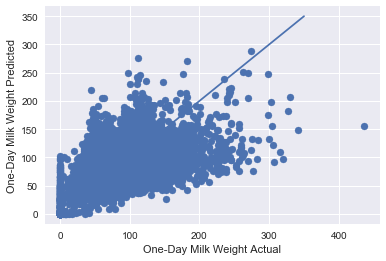

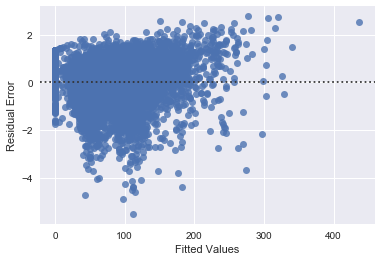

In [20]:
# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='median', axis=0)), 
         ('scalar', StandardScaler()),
         ('forest', RandomForestRegressor())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'forest__n_estimators':np.arange(2, 15, 2),
              'forest__max_features':['auto', 'sqrt', 'log2']}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create the GridSearchCV object: gm_cv
m_cv = GridSearchCV(pipeline, cv=3, param_grid=parameters)

# Fit to the training set
m_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = m_cv.score(X_test, y_test)
print("Best Paremeters: {}".format(m_cv.best_params_))
print("CV_Score: {}".format(r2))

y_pred = m_cv.predict(X_test)
plot_model_scatter_plot(y_test, y_pred)

In [21]:
predicted = m_cv.predict(X)

In [22]:
data['milk_weight_predicted'] = predicted
output = data[['milk_weight_predicted', 'milk_weight', 'days_since_calving', 'age_in_months', \
             'dairy_form', 'udder_score_aggregate', 'dairy_strength_aggregate', 'final_score', \
             'breed_age_average', 'milk_score', 'ctpi']]

In [23]:
output.sample(10)

,milk_weight_predicted,milk_weight,days_since_calving,age_in_months,dairy_form,udder_score_aggregate,dairy_strength_aggregate,final_score,breed_age_average,milk_score,ctpi
40028,70.850000,83.6,130.0,40.0,24.0,79.0,78.0,78.0,100.900002,-238,1643
53085,96.778571,112.4,127.0,80.0,29.0,86.0,85.0,85.0,106.000000,-84,1618
11013,53.185714,44.1,197.0,65.0,45.0,84.0,88.0,85.0,106.000000,-608,1493
5471,55.571429,68.1,225.0,72.0,35.0,83.0,86.0,85.0,107.199997,31,1534
22920,84.721429,92.0,236.0,58.0,31.0,83.0,86.0,83.0,107.199997,805,1950
43042,107.300000,111.5,44.0,38.0,25.0,74.0,83.0,77.0,99.800003,330,1648
56567,51.042857,50.7,273.0,68.0,38.0,86.0,85.0,85.0,107.199997,-36,1567
32328,86.228571,85.6,152.0,43.0,28.0,79.0,78.0,79.0,101.199997,1004,1761
45684,57.971429,46.8,264.0,-18.0,35.0,81.0,87.0,85.0,106.000000,-338,1520
30909,83.071429,86.6,17.0,37.0,23.0,85.0,82.0,82.0,103.599998,486,1835
